# Accessibility Analysis

- This analysis will measure accessibility to health facilities by health facility type
- origins are derived from GHS

- The OD matrix were too intense, so the Graph Tool is used to calculate the OD matrix.

- Advanced accessibility measures are being generated in the end, including average pop served by slot per mahalla

### Import libraries

In [20]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [21]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTnets')
import GOSTnets as gn

In [22]:
from GOSTnets.fetch_pois import *

In [23]:
# define input folder
inputFolder = r'input_folder'

# define output folder
outputFolder = r'output_folder'

# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [24]:
city_name = 'namangan'

In [25]:
origins_file = os.path.join(inputFolder, "namangan_ghs_pts_mahallas_100m.shp")

In [26]:
# import extent
extent = gpd.read_file("admin/namangan_overall_mahalla_aoi.shp")

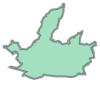

In [27]:
extent.geometry[0]

In [28]:
# import POI extent
POI_extent = gpd.read_file("admin/namangan_overall_mahalla_aoi.shp")

## We will extract the Roads and convert into a graph

In [36]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*shapely.total_bounds(extent))
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largest subgraph
   
    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph

    #nx.write_gpickle(G, roadGraph)
    pd.to_pickle(G, roadGraph)
else:
    G = pd.read_pickle(roadGraph)
    
    G = gn.convert_network_to_time(G, 'length')

### Inspect the road graph as a shapefile

In [37]:
roads = gn.edge_gdf_from_graph(G)

### Sometimes the highway value can have a list instead of a single value, in these cases the code below will replace the list with the first value of the list

In [38]:
def replace_hwy(x):
    if isinstance(x, list):
        x = x[0]
    return x

In [39]:
roads['highway'] = roads.apply(lambda x: replace_hwy(x['highway']), axis=1)

In [40]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    #roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

## Snap origins to the road graph using advanced snapping

In [41]:
# insert origins
origins = gpd.read_file(origins_file)

In [42]:
origins['osmid'] = 1110000000 + origins.index
origins

,VALUE,geometry,osmid
0,0.009796,POINT (71.67014 41.14689),1110000000
1,3.193340,POINT (71.67195 41.14689),1110000001
2,1.782785,POINT (71.66652 41.13878),1110000002
3,2.223583,POINT (71.67014 41.13788),1110000003
4,0.166524,POINT (71.67014 41.13518),1110000004
...,...,...,...
9378,32.158699,POINT (71.60503 40.96137),1110009378
9379,39.348614,POINT (71.59598 40.96047),1110009379
9380,14.507169,POINT (71.59779 40.96047),1110009380
9381,25.536926,POINT (71.59960 40.96047),1110009381


In [43]:
# find graph utm zone
G_utm = gn.utm_of_graph(G)
G_utm

'+proj=utm +zone=42 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

## snapping origins to graph using advanced snapping

In [44]:
%%time
G2, pois_meter, new_footway_edges = gn.advanced_snap(G, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='osmid', poi_key_col='osmid', threshold=2000, measure_crs=G_utm, verbose=True)

print edges_meter
Building rtree...
finished Building rtree
seconds elapsed: 1.1661300659179688
updating external nodes (pois)
finished updating external nodes (pois)
seconds elapsed: 1.170341968536377
Projecting POIs to the network...2
finished pois_meter['near_idx'] and pois_meter['near_lines']
seconds elapsed: 4.315387010574341
finished pois_meter['kne_idx']
seconds elapsed: 4.876168966293335
assigning a projected point to each POI
finished assigning a projected point to each POI
seconds elapsed: 5.028287887573242
Updating internal nodes...
finished Updating internal nodes
seconds elapsed: 5.439327955245972
print _new_nodes
Updating internal edges...
finished creating line_pps_dict
seconds elapsed: 5.946976900100708
creating new_lines


/Users/tomgertin/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/shapely/linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


finished creating new_lines
seconds elapsed: 7.387868165969849
Updating update_edges
after
0        LINESTRING (728115.327 4539584.813, 728181.482...
1        LINESTRING (728181.482 4539544.049, 728289.688...
2        LINESTRING (728289.688 4539477.374, 728293.484...
3        LINESTRING (728115.327 4539584.813, 728145.294...
4        LINESTRING (728145.294 4539620.040, 728164.725...
                               ...                        
14666    LINESTRING (720633.391 4542192.465, 720647.027...
14667    LINESTRING (720514.288 4542265.713, 720529.139...
14668    LINESTRING (720615.083 4542075.960, 720652.286...
14669    LINESTRING (720609.884 4541994.260, 720611.525...
14670    LINESTRING (720625.554 4541993.339, 720674.884...
Name: geometry, Length: 14671, dtype: geometry
debugging
finished Updating update_edges
seconds elapsed: 8.338794946670532
Updating external links...
debugging
node count before: 32635
node count after: 32635
pois_meter count before: 9383
pois_meter count afte

In [45]:
pois_meter

,VALUE,geometry,osmid,near_idx,near_lines,kne_idx,pp
0,0.009796,POINT (71.67014 41.14689),1110000000,"[9739, 9747, 9740, 9761, 9743]","9739 LINESTRING (724714.832 4558681.245, 72...",9739,POINT (724302.5246049243 4558453.080036933)
1,3.193340,POINT (71.67195 41.14689),1110000001,"[9739, 9747, 9740, 9743, 9742]","9739 LINESTRING (724714.832 4558681.245, 72...",9739,POINT (724308.2385534326 4558472.448309777)
2,1.782785,POINT (71.66652 41.13878),1110000002,"[10413, 9761, 9762, 10412, 9739]","10413 LINESTRING (724168.515 4557460.124, 7...",10413,POINT (723788.9846952372 4557626.799940396)
3,2.223583,POINT (71.67014 41.13788),1110000003,"[10413, 9761, 9762, 10412, 9739]","10413 LINESTRING (724168.515 4557460.124, 7...",10413,POINT (724153.68013264 4557495.624462205)
4,0.166524,POINT (71.67014 41.13518),1110000004,"[9762, 9761, 9763, 10391, 10413]","9762 LINESTRING (724131.425 4557159.615, 7...",9762,POINT (724134.4415605763 4557198.77682075)
...,...,...,...,...,...,...,...
9378,32.158699,POINT (71.60503 40.96137),1110009378,"[10373, 10377, 10376, 10374, 14249]","10373 LINESTRING (719293.953 4537760.651, 7...",10373,POINT (719229.7255157449 4537727.811103196)
9379,39.348614,POINT (71.59598 40.96047),1110009379,"[11530, 11532, 11527, 11526, 11529]","11530 LINESTRING (718427.998 4537641.778, 7...",11530,POINT (718460.882210693 4537607.960024727)
9380,14.507169,POINT (71.59779 40.96047),1110009380,"[11524, 11527, 11525, 11519, 11522]","11524 LINESTRING (718556.156 4537712.950, 7...",11524,POINT (718632.8468567701 4537631.208321593)
9381,25.536926,POINT (71.59960 40.96047),1110009381,"[13708, 11522, 13709, 11520, 11521]","13708 LINESTRING (718724.559 4537699.802, 7...",13708,POINT (718776.4218696785 4537626.479845658)


In [46]:
pois_meter_list = list(pois_meter['osmid'])

## run convert_network_to_time so that projected footway edges will have times

In [47]:
G2 = gn.convert_network_to_time(G2, 'length')

/Users/tomgertin/repos/valhalla_GOST_PublicGoods/namangan/../../GOSTnets/GOSTnets/core.py:1024: UserWarning: Aree you sure you want to convert length to time? This graph already has a time attribute
  warnings.warn('Aree you sure you want to convert length to time? This graph already has a time attribute')


In [48]:
pois_meter

,VALUE,geometry,osmid,near_idx,near_lines,kne_idx,pp
0,0.009796,POINT (71.67014 41.14689),1110000000,"[9739, 9747, 9740, 9761, 9743]","9739 LINESTRING (724714.832 4558681.245, 72...",9739,POINT (724302.5246049243 4558453.080036933)
1,3.193340,POINT (71.67195 41.14689),1110000001,"[9739, 9747, 9740, 9743, 9742]","9739 LINESTRING (724714.832 4558681.245, 72...",9739,POINT (724308.2385534326 4558472.448309777)
2,1.782785,POINT (71.66652 41.13878),1110000002,"[10413, 9761, 9762, 10412, 9739]","10413 LINESTRING (724168.515 4557460.124, 7...",10413,POINT (723788.9846952372 4557626.799940396)
3,2.223583,POINT (71.67014 41.13788),1110000003,"[10413, 9761, 9762, 10412, 9739]","10413 LINESTRING (724168.515 4557460.124, 7...",10413,POINT (724153.68013264 4557495.624462205)
4,0.166524,POINT (71.67014 41.13518),1110000004,"[9762, 9761, 9763, 10391, 10413]","9762 LINESTRING (724131.425 4557159.615, 7...",9762,POINT (724134.4415605763 4557198.77682075)
...,...,...,...,...,...,...,...
9378,32.158699,POINT (71.60503 40.96137),1110009378,"[10373, 10377, 10376, 10374, 14249]","10373 LINESTRING (719293.953 4537760.651, 7...",10373,POINT (719229.7255157449 4537727.811103196)
9379,39.348614,POINT (71.59598 40.96047),1110009379,"[11530, 11532, 11527, 11526, 11529]","11530 LINESTRING (718427.998 4537641.778, 7...",11530,POINT (718460.882210693 4537607.960024727)
9380,14.507169,POINT (71.59779 40.96047),1110009380,"[11524, 11527, 11525, 11519, 11522]","11524 LINESTRING (718556.156 4537712.950, 7...",11524,POINT (718632.8468567701 4537631.208321593)
9381,25.536926,POINT (71.59960 40.96047),1110009381,"[13708, 11522, 13709, 11520, 11521]","13708 LINESTRING (718724.559 4537699.802, 7...",13708,POINT (718776.4218696785 4537626.479845658)


In [49]:
originNodes_list = list(origins['osmid'])

In [50]:
originNodes_list

[1110000000,
 1110000001,
 1110000002,
 1110000003,
 1110000004,
 1110000005,
 1110000006,
 1110000007,
 1110000008,
 1110000009,
 1110000010,
 1110000011,
 1110000012,
 1110000013,
 1110000014,
 1110000015,
 1110000016,
 1110000017,
 1110000018,
 1110000019,
 1110000020,
 1110000021,
 1110000022,
 1110000023,
 1110000024,
 1110000025,
 1110000026,
 1110000027,
 1110000028,
 1110000029,
 1110000030,
 1110000031,
 1110000032,
 1110000033,
 1110000034,
 1110000035,
 1110000036,
 1110000037,
 1110000038,
 1110000039,
 1110000040,
 1110000041,
 1110000042,
 1110000043,
 1110000044,
 1110000045,
 1110000046,
 1110000047,
 1110000048,
 1110000049,
 1110000050,
 1110000051,
 1110000052,
 1110000053,
 1110000054,
 1110000055,
 1110000056,
 1110000057,
 1110000058,
 1110000059,
 1110000060,
 1110000061,
 1110000062,
 1110000063,
 1110000064,
 1110000065,
 1110000066,
 1110000067,
 1110000068,
 1110000069,
 1110000070,
 1110000071,
 1110000072,
 1110000073,
 1110000074,
 1110000075,
 1110000076,

In [51]:
print('pause here')

pause here


### Snap destinations to the road graph

In [52]:
G_adv_pt_gdf = gn.node_gdf_from_graph(G2)
G_adv_poi_pts = G_adv_pt_gdf.loc[G_adv_pt_gdf['highway'] != 'poi']

In [53]:
destinations_file = os.path.join(inputFolder, "namangan_healthcare_geo3.shp")
destinations = gpd.read_file(destinations_file, encoding='utf-8')

In [54]:
destinations

,id,Name of th,District,Mahalla,Capacity,Year of co,Building t,Type of fa,Total area,latitude,longitude,Type code,Accessibil,geometry
0,1,??????? ??????????,Yangi Namangan District,?????,300,1992-2021 ?,???????,Hospital for children,4.10,41.017962,71.663141,4,only distance,POINT (71.66314 41.01796)
1,2,?????? ?????????,Namangan city,???? ???????,230,1987,???????,Maternity hospital,2.40,41.004589,71.705662,2,only distance,POINT (71.70566 41.00459)
2,3,2-?????? ?????????,Yangi Namangan District,?????????,120,1960,??????????????,Maternity hospital,0.61,41.006276,71.626536,2,only distance,POINT (71.62654 41.00628)
3,4,????? ????? ????? ??????????,Yangi Namangan District,??????,60,1976,??????????????,Tuberculosis dispensary,0.00,41.005842,71.631654,3,distance & capacity,POINT (71.63165 41.00584)
4,5,???????? ????????,Namangan city,???????,250,1976-2014,???????,Central hospital,1.08,40.980288,71.702703,1,only distance,POINT (71.70270 40.98029)
5,6,??? ???????? ???????? ???????????,Namangan city,???????????,850,1986,???????,Multy purpose polyclinic,0.46,41.000334,71.665191,3,distance & capacity,POINT (71.66519 41.00033)
6,7,1-???? ???????????,Namangan city,????????,500,1982,??????????????,Family polyclinic,0.04,40.992619,71.669737,3,distance & capacity,POINT (71.66974 40.99262)
7,8,2-???? ???????????,Namangan city,????,250,1984,??????????????,Family polyclinic,0.15,41.007444,71.679875,3,distance & capacity,POINT (71.67987 41.00744)
8,9,3-???? ???????????,Namangan city,??????,220,1980,??????????????,Family polyclinic,0.40,40.992920,71.648201,3,distance & capacity,POINT (71.64820 40.99292)
9,10,4-???? ???????????,Namangan city,???????,250,1977,??????????????,Family polyclinic,0.41,40.980288,71.702703,3,distance & capacity,POINT (71.70270 40.98029)


In [55]:
# pause

In [56]:
snapped_destinations_df = gn.pandana_snap_c(G_adv_poi_pts, destinations, source_crs = 'epsg:4326', target_crs=G_utm)

In [57]:
snapped_destinations_df

,id,Name of th,District,Mahalla,Capacity,Year of co,Building t,Type of fa,Total area,latitude,longitude,Type code,Accessibil,geometry,NN,NN_dist
0,1,??????? ??????????,Yangi Namangan District,?????,300,1992-2021 ?,???????,Hospital for children,4.10,41.017962,71.663141,4,only distance,POINT (71.66314 41.01796),9990003803,33.177458
1,2,?????? ?????????,Namangan city,???? ???????,230,1987,???????,Maternity hospital,2.40,41.004589,71.705662,2,only distance,POINT (71.70566 41.00459),7941221390,35.684742
2,3,2-?????? ?????????,Yangi Namangan District,?????????,120,1960,??????????????,Maternity hospital,0.61,41.006276,71.626536,2,only distance,POINT (71.62654 41.00628),9990004949,14.282915
3,4,????? ????? ????? ??????????,Yangi Namangan District,??????,60,1976,??????????????,Tuberculosis dispensary,0.00,41.005842,71.631654,3,distance & capacity,POINT (71.63165 41.00584),9990005036,50.220249
4,5,???????? ????????,Namangan city,???????,250,1976-2014,???????,Central hospital,1.08,40.980288,71.702703,1,only distance,POINT (71.70270 40.98029),9990007239,81.903660
5,6,??? ???????? ???????? ???????????,Namangan city,???????????,850,1986,???????,Multy purpose polyclinic,0.46,41.000334,71.665191,3,distance & capacity,POINT (71.66519 41.00033),9990005564,44.825112
6,7,1-???? ???????????,Namangan city,????????,500,1982,??????????????,Family polyclinic,0.04,40.992619,71.669737,3,distance & capacity,POINT (71.66974 40.99262),7962483351,34.649233
7,8,2-???? ???????????,Namangan city,????,250,1984,??????????????,Family polyclinic,0.15,41.007444,71.679875,3,distance & capacity,POINT (71.67987 41.00744),1792979782,12.164186
8,9,3-???? ???????????,Namangan city,??????,220,1980,??????????????,Family polyclinic,0.40,40.992920,71.648201,3,distance & capacity,POINT (71.64820 40.99292),9990006176,19.938328
9,10,4-???? ???????????,Namangan city,???????,250,1977,??????????????,Family polyclinic,0.41,40.980288,71.702703,3,distance & capacity,POINT (71.70270 40.98029),9990007239,81.863420


In [58]:
len(pois_meter_list)

9383

In [59]:
pois_meter

,VALUE,geometry,osmid,near_idx,near_lines,kne_idx,pp
0,0.009796,POINT (71.67014 41.14689),1110000000,"[9739, 9747, 9740, 9761, 9743]","9739 LINESTRING (724714.832 4558681.245, 72...",9739,POINT (724302.5246049243 4558453.080036933)
1,3.193340,POINT (71.67195 41.14689),1110000001,"[9739, 9747, 9740, 9743, 9742]","9739 LINESTRING (724714.832 4558681.245, 72...",9739,POINT (724308.2385534326 4558472.448309777)
2,1.782785,POINT (71.66652 41.13878),1110000002,"[10413, 9761, 9762, 10412, 9739]","10413 LINESTRING (724168.515 4557460.124, 7...",10413,POINT (723788.9846952372 4557626.799940396)
3,2.223583,POINT (71.67014 41.13788),1110000003,"[10413, 9761, 9762, 10412, 9739]","10413 LINESTRING (724168.515 4557460.124, 7...",10413,POINT (724153.68013264 4557495.624462205)
4,0.166524,POINT (71.67014 41.13518),1110000004,"[9762, 9761, 9763, 10391, 10413]","9762 LINESTRING (724131.425 4557159.615, 7...",9762,POINT (724134.4415605763 4557198.77682075)
...,...,...,...,...,...,...,...
9378,32.158699,POINT (71.60503 40.96137),1110009378,"[10373, 10377, 10376, 10374, 14249]","10373 LINESTRING (719293.953 4537760.651, 7...",10373,POINT (719229.7255157449 4537727.811103196)
9379,39.348614,POINT (71.59598 40.96047),1110009379,"[11530, 11532, 11527, 11526, 11529]","11530 LINESTRING (718427.998 4537641.778, 7...",11530,POINT (718460.882210693 4537607.960024727)
9380,14.507169,POINT (71.59779 40.96047),1110009380,"[11524, 11527, 11525, 11519, 11522]","11524 LINESTRING (718556.156 4537712.950, 7...",11524,POINT (718632.8468567701 4537631.208321593)
9381,25.536926,POINT (71.59960 40.96047),1110009381,"[13708, 11522, 13709, 11520, 11521]","13708 LINESTRING (718724.559 4537699.802, 7...",13708,POINT (718776.4218696785 4537626.479845658)


In [60]:
pois_meter_osmid = pois_meter[['osmid']]
pois_meter_osmid_joined = pois_meter_osmid.merge(origins, how='inner', left_on='osmid', right_on='osmid')

In [61]:
pois_meter_osmid_joined

,osmid,VALUE,geometry
0,1110000000,0.009796,POINT (71.67014 41.14689)
1,1110000001,3.193340,POINT (71.67195 41.14689)
2,1110000002,1.782785,POINT (71.66652 41.13878)
3,1110000003,2.223583,POINT (71.67014 41.13788)
4,1110000004,0.166524,POINT (71.67014 41.13518)
...,...,...,...
9378,1110009378,32.158699,POINT (71.60503 40.96137)
9379,1110009379,39.348614,POINT (71.59598 40.96047)
9380,1110009380,14.507169,POINT (71.59779 40.96047)
9381,1110009381,25.536926,POINT (71.59960 40.96047)


In [ ]:
# pause here

In [ ]:
 #destinationNodes = list(snapped_destinations_df['NN'].unique())

In [205]:
import pickle

In [206]:
#uncommment below
#pois_meter_osmid.to_pickle('export_to_graph_tool/origins.pickle')

In [43]:
# test
snapped_destinations_df.loc[snapped_destinations_df['Type code']==4]

,id,Name of th,District,Mahalla,Capacity,Year of co,Building t,Type of fa,Total area,latitude,longitude,Type code,Accessibil,geometry,NN,NN_dist
0,1,??????? ??????????,Yangi Namangan District,?????,300,1992-2021 ?,???????,Hospital for children,4.1,41.017962,71.663141,4,only distance,POINT (71.66314 41.01796),9990003803,33.177458


In [104]:
snapped_destinations_df.loc[snapped_destinations_df['Type code']==2]

,id,Name of th,District,Mahalla,Capacity,Year of co,Building t,Type of fa,Total area,latitude,longitude,Type code,Accessibil,geometry,NN,NN_dist
1,2,?????? ?????????,Namangan city,???? ???????,230,1987,???????,Maternity hospital,2.40,41.004589,71.705662,2,only distance,POINT (71.70566 41.00459),7941221390,35.684742
2,3,2-?????? ?????????,Yangi Namangan District,?????????,120,1960,??????????????,Maternity hospital,0.61,41.006276,71.626536,2,only distance,POINT (71.62654 41.00628),9990004949,14.282915
21,23,1-??????????,Davlatobod District,"""???????"" ???",95,2017,???????,Maternity hospital,0.65,40.998742,71.591527,2,only distance,POINT (71.59153 40.99874),297163035,70.303509


In [58]:
for val in snapped_destinations_df['Type code'].unique():
    print(val)
    #print(snapped_destinations_df.loc[snapped_destinations_df['Type code']==val])
    #print(list(snapped_destinations_df.loc[snapped_destinations_df['Type code']==val]['NN']))
    print(snapped_destinations_df.loc[snapped_destinations_df['Type code']==val][['NN']])
    dest_list = snapped_destinations_df.loc[snapped_destinations_df['Type code']==val][['NN']]
    #uncommment below
    #dest_list.to_pickle(f'export_to_graph_tool/destinations_healthcare_geo2_{val}.pickle')

4
           NN
0  9990003803
2
            NN
1   7941221390
2   9990004949
21   297163035
3
            NN
3   9990005036
5   9990005564
6   7962483351
7   1792979782
8   9990006176
9   9990007239
10  7950246134
11  1792979782
12  7941606045
13  7941466158
14  7949949127
15  9990003093
16  7941681061
17  9990005536
18  6751938587
19  7579580080
20  9990000987
22  9990000950
23  9990000354
24  9990003215
25  9990003134
26  7953211386
27  9990005036
28  9990000560
1
           NN
4  9990007239


In [57]:
snapped_destinations_df.loc[snapped_destinations_df['Type code']==3][['NN']]

,NN
3,9990005036
5,9990005564
6,7962483351
7,1792979782
8,9990006176
9,9990007239
10,7950246134
11,1792979782
12,7941606045
13,7941466158


In [50]:
dest_list

4    9990007239
Name: NN, dtype: int64

In [207]:
#snapped_destinations_df[['NN']].to_pickle(f'export_to_graph_tool/destinations_healthcare_geo2_{val}.pickle')

In [49]:
#snapped_destinations_df[['NN']]

In [208]:
G2_export = G2.copy()

In [209]:
G_adv_edges2 = gn.edge_gdf_from_graph(G2_export)
# testing
G_adv_edges2[:3]

,stnode,endnode,length,junction,time,highway,mode,name,osmid,lanes,access,tunnel,service,bridge,maxspeed,oneway,ref,geometry
0,295699553,7352848712,33.165,NaN,2.98485,primary,drive,Улица Бабура,720218202,NaN,NaN,NaN,NaN,NaN,NaN,False,P-112,"LINESTRING (71.72649 40.97133, 71.72684 40.97120)"
1,295699553,5780435512,47.410,NaN,4.26690,primary,drive,Улица Бабура,720218202,NaN,NaN,NaN,NaN,NaN,NaN,False,P-112,"LINESTRING (71.72649 40.97133, 71.72598 40.97152)"
2,295699553,2050899677,82.959,NaN,9.95508,secondary,drive,NaN,27702488,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,"LINESTRING (71.72649 40.97133, 71.72631 40.971..."


In [210]:
for n1, n2, data in G2_export.edges(data=True):
    #print(data)
    del data['highway']
    del data['oneway']
    del data['mode']
    del data['name']
    #del data['width']
    del data['maxspeed']
    #del data['junction']
    del data['tunnel']
    del data['ref']
    del data['bridge']
    del data['lanes']
    del data['service']
    del data['access']
    del data['junction']

In [211]:
G_adv_nodes2 = gn.node_gdf_from_graph(G2_export)
# testing
G_adv_nodes2[:3]

,node_ID,y,highway,street_count,x,geometry
0,295699553,40.971327,NaN,3.0,71.726488,POINT (71.72649 40.97133)
1,7352848712,40.971198,NaN,3.0,71.726844,POINT (71.72684 40.97120)
2,5780435512,40.971519,NaN,4.0,71.725984,POINT (71.72598 40.97152)


In [212]:
for node, data in G2_export.nodes(data=True):
    #print(data)
    del data['highway']

In [213]:
gn.save(G2_export, 'G2_export3', 'export_to_graph_tool', pickle=True, edges=False, nodes=False)

In [214]:
nx.__version__

'2.6.3'

In [215]:
print('pause here')

pause here


In [6]:
#uncommment below
#OD_matrix = nx.read_gpickle(r'graph_tool_output/OD_matrix_healthcare_geo2_1.pickle')
#OD_matrix

In [7]:
OD_matrix

,9990007239
1110000000,2484.619229
1110000001,2332.128565
1110000002,2295.851760
1110000003,2230.530270
1110000004,2145.911836
...,...
1110009378,1120.253108
1110009379,1258.325360
1110009380,1236.243603
1110009381,1195.352985


In [116]:
# calculate OD matrix
#total_amenities_OD_matrix = gn.calculate_OD(G2, pois_meter_list, destinationNodes, fail_value=-1, weight='time', one_way_roads_exist = True, verbose=False)

/opt/conda/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
pois_meter_osmid_joined

,osmid,VALUE,geometry
0,1110000000,0.009796,POINT (71.67014 41.14689)
1,1110000001,3.193340,POINT (71.67195 41.14689)
2,1110000002,1.782785,POINT (71.66652 41.13878)
3,1110000003,2.223583,POINT (71.67014 41.13788)
4,1110000004,0.166524,POINT (71.67014 41.13518)
...,...,...,...
9378,1110009378,32.158699,POINT (71.60503 40.96137)
9379,1110009379,39.348614,POINT (71.59598 40.96047)
9380,1110009380,14.507169,POINT (71.59779 40.96047)
9381,1110009381,25.536926,POINT (71.59960 40.96047)


In [219]:
#pd.DataFrame([pois_meter, closest_facility_per_origin])

In [220]:
#closest_facility_per_origin.values

In [221]:
OD_matrix

,7941221390,9990003215,9990003093,7962483351,297163035,6751938587,7941606045,9990006176,9990005536,7941681061,...,9990000950,9990005564,1792979782,9990007239,7949949127,9990004949,7950246105,9990003803,7950246134,7953211386
1110000000,2430.960145,2408.838537,2702.787113,2274.171029,2767.681498,2665.228748,2569.724551,2413.629716,2604.911257,2659.326438,...,2309.334084,2239.561108,2054.460277,2493.947135,2273.926550,2509.101944,2478.774221,2030.977279,2380.732920,2050.779887
1110000001,2278.469481,2256.347874,2550.296450,2121.680366,2615.190835,2512.738084,2417.233888,2261.139053,2452.420594,2506.835775,...,2156.843420,2087.070445,1901.969614,2341.456471,2121.435887,2356.611281,2326.283558,1878.486616,2228.242257,1898.289223
1110000002,2242.192676,2220.071069,2514.019645,2085.403560,2578.914030,2476.461279,2380.957082,2224.862248,2416.143789,2470.558970,...,2120.566615,2050.793640,1865.692809,2305.179666,2085.159082,2320.334475,2290.006752,1842.209811,2191.965452,1862.012418
1110000003,2176.871186,2154.749579,2448.698155,2020.082070,2513.592540,2411.139789,2315.635592,2159.540758,2350.822298,2405.237480,...,2055.245125,1985.472150,1800.371319,2239.858176,2019.837592,2255.012985,2224.685262,1776.888321,2126.643962,1796.690928
1110000004,2092.252752,2070.131145,2364.079720,1935.463636,2428.974105,2326.521355,2231.017158,2074.922323,2266.203864,2320.619045,...,1970.626691,1900.853716,1715.752885,2155.239742,1935.219158,2170.394551,2140.066828,1692.269887,2042.025528,1712.072494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110009378,1313.485811,1247.567271,1969.158182,851.504889,840.595441,819.386246,1452.250217,892.390700,878.471910,1541.852104,...,1869.555002,943.230178,1072.393786,1120.253108,1176.083051,1016.641511,770.444526,1263.031159,806.949954,1286.174391
1110009379,1451.558063,1300.615484,2107.230434,989.577142,893.643654,872.434459,1590.322469,1030.462952,931.520123,1679.924356,...,1941.552213,1081.302431,1210.466038,1258.325360,1314.155304,1069.689724,908.516779,1401.103411,945.022207,1424.246644
1110009380,1429.476306,1332.873251,2085.148677,967.495385,925.901421,904.692226,1568.240712,1008.381195,963.777890,1657.842599,...,1973.809980,1059.220673,1188.384281,1236.243603,1292.073546,1101.947491,886.435021,1379.021654,922.940450,1402.164886
1110009381,1388.585687,1309.604271,2044.258058,926.604766,902.632441,881.423246,1527.350093,967.490577,940.508910,1616.951981,...,1944.654879,1018.330055,1147.493662,1195.352985,1251.182928,1078.678511,845.544403,1338.131035,882.049831,1361.274268


## To-do: Get a list of all origins that belong to each hospital

In [62]:
import geopandas

In [1]:
def calc_accessibility(OD_matrix, only_facilities=False):
    
    time_to_closest_facility_per_origin = OD_matrix.min(axis=1)
    closest_facility_per_origin = OD_matrix.idxmin(1)
    
    # add time to closest facility and closest facility per origins
    pois_meter_osmid_joined2 = pois_meter_osmid_joined.merge(time_to_closest_facility_per_origin.to_frame(), left_on='osmid', right_index=True)
    results = pois_meter_osmid_joined2.merge(closest_facility_per_origin.to_frame(), left_on='osmid', right_index=True)
    # rename columns
    results.columns = ['osmid', 'pop', 'geometry', 'tt_to_closest_fac', 'closest_fac_per_origin']
    
    # group by for facilities
    fac_results = results.groupby('closest_fac_per_origin')
    fac_results_agg = fac_results.agg({'tt_to_closest_fac' : 'mean', 'pop' : 'sum'})
    # add facility geometries
    snapped_destinations_df_slim = snapped_destinations_df[['id', 'Capacity', 'geometry', 'NN', 'NN_dist']]
    final_fac_results = snapped_destinations_df_slim.merge(fac_results_agg, left_on='NN', right_on='closest_fac_per_origin')
    # rename columns
    final_fac_results.columns = ['facid', 'capacity', 'geometry', 'NN', 'NN_dist', 'avg_tt_to_closest_fac', 'fac_pop_served']
    # calculate the population in service area per slot (capacity)
    final_fac_results['pop_per_cap'] = final_fac_results['fac_pop_served'] / final_fac_results['capacity']
    
    results_gdf = geopandas.GeoDataFrame(results, geometry='geometry')
    
    #return results_gdf
    #return results_gdf,final_fac_results
    if only_facilities==True:
        return final_fac_results
    
    mahalla_GDF = gpd.read_file(r"../mahalla_aois/namangan_mahallas.shp", encoding='utf-8')
    results_gdf = gpd.sjoin(mahalla_GDF,results_gdf, how="left")
    
    #To do the weighted average:
    #1. Sum the population of all cells within the mahallas
    mahalla_pop = results_gdf.groupby('MFY_nomi').agg(mahalla_pop_sum=('pop','sum'))
    origins_w_mahalla_pop_sum = results_gdf.merge(mahalla_pop, left_on='MFY_nomi',right_index=True)
    #2. Compute the weights (value between 0-1) as the ratio between the cell's population and the sum of population within the mahalla where the cell is located
    origins_w_mahalla_pop_sum['mahalla_pop_ratio'] = origins_w_mahalla_pop_sum['pop'] / origins_w_mahalla_pop_sum['mahalla_pop_sum']
    #3. For each cell multiply the travel time to the closest facility by the weight
    origins_w_mahalla_pop_sum['tt_mult_mahalla_pop_ratio'] = origins_w_mahalla_pop_sum['tt_to_closest_fac'] * origins_w_mahalla_pop_sum['mahalla_pop_ratio']
    #4. Within each mahalla sum all the values computed at stage 3
    mean_weighted = origins_w_mahalla_pop_sum.groupby('MFY_nomi').agg(mean_weighted=('tt_mult_mahalla_pop_ratio','sum'))
    
    mahalla_GDF_w_mean_weighted = pd.merge(mahalla_GDF, mean_weighted, left_on='MFY_nomi',right_index=True, how='outer')
    mahalla_GDF_w_mean_weighted = pd.merge(mahalla_GDF_w_mean_weighted, mahalla_pop, left_on='MFY_nomi',right_index=True, how='outer')
    mean_tt_per_mahalla = results_gdf.groupby('MFY_nomi')['tt_to_closest_fac'].agg(['mean'])
    mahalla_GDF_w_mean_weighted_final = pd.merge(mahalla_GDF_w_mean_weighted, mean_tt_per_mahalla, left_on='MFY_nomi',right_index=True,how='outer')
    
    #return mahalla_GDF_w_mean_weighted_final
    
    #compute average pop per cap per mahalla
    merge_cap_per_pop = results.merge(final_fac_results, left_on='closest_fac_per_origin', right_on='NN')
    merge_cap_per_pop_gdf = geopandas.GeoDataFrame(merge_cap_per_pop, geometry='geometry_x')
    points_polys_cap_per_pop = gpd.sjoin(mahalla_GDF, merge_cap_per_pop_gdf, how="left")
    stats_pt_cap_per_pop_per_mahalla = points_polys_cap_per_pop.groupby('MFY_nomi').agg(pop_per_cap_mahalla_avg=('pop_per_cap','mean'))
    final_results_mahallas = pd.merge(mahalla_GDF_w_mean_weighted_final, stats_pt_cap_per_pop_per_mahalla, left_on='MFY_nomi', right_index=True,how='outer')
    
    return final_results_mahallas

In [64]:
#type(final_results_mahallas)

In [65]:
import pickle

In [66]:
import pandas

In [67]:
# output facility points
# for networkX ver 3
with open(f'graph_tool_output/OD_matrix_healthcare_geo2_3.pickle', 'rb') as f:
    OD_matrix = pd.read_pickle(f)
#OD_matrix = nx.read_gpickle(f'graph_tool_output/OD_matrix_healthcare_geo2_3.pickle')
final_results_facilities = calc_accessibility(OD_matrix, only_facilities=True)

In [68]:
final_results_facilities

,facid,capacity,geometry,NN,NN_dist,avg_tt_to_closest_fac,fac_pop_served,pop_per_cap
0,4,60,POINT (71.63165 41.00584),9990005036,50.220249,247.649321,7693.501519,128.225025
1,#REF!,220,POINT (71.63165 41.00584),9990005036,50.220249,247.649321,7693.501519,34.970461
2,5,250,POINT (71.70270 40.98029),9990007239,81.903660,256.244512,23833.936702,95.335747
3,10,250,POINT (71.70270 40.98029),9990007239,81.863420,256.244512,23833.936702,95.335747
4,6,850,POINT (71.66519 41.00033),9990005564,44.825112,188.749893,8455.627984,9.947798
5,7,500,POINT (71.66974 40.99262),7962483351,34.649233,290.211808,16945.293684,33.890587
6,8,250,POINT (71.67987 41.00744),1792979782,12.164186,230.463620,12906.635934,51.626544
7,13,250,POINT (71.67985 41.00744),1792979782,10.065192,230.463620,12906.635934,51.626544
8,9,220,POINT (71.64820 40.99292),9990006176,19.938328,294.447200,18336.363267,83.347106
9,11,150,POINT (71.66799 40.98313),7950246134,40.969552,301.162548,16279.137804,108.527585


In [70]:
final_results_facilities.to_file(outputFolder + '/'+ city_name + 'final_results_facilities_type3' + '.shp', encoding='utf-8')

/var/folders/gr/04wfn6914nn08mfvwlf0_j2h0000gn/T/ipykernel_55124/786647850.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_results_facilities.to_file(outputFolder + '/'+ city_name + 'final_results_facilities_type3' + '.shp', encoding='utf-8')


In [119]:
for val in snapped_destinations_df['Type code'].unique():
    print(val)
    OD_matrix = nx.read_gpickle(f'graph_tool_output/OD_matrix_healthcare_geo2_{val}.pickle')
    final_results_mahallas = calc_accessibility(OD_matrix)
    final_results_mahallas.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_mahallas_type_' + str(val) + '.shp', encoding='utf-8')
    final_results_mahallas.to_csv(outputFolder + '/'+ city_name + '_accessibility_hospitals_mahallas_type_' + str(val) + '.csv', encoding='utf-8')

4


<ipython-input-119-e6b8896511d8>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_results_mahallas.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_mahallas_type_' + str(val) + '.shp', encoding='utf-8')


2


<ipython-input-119-e6b8896511d8>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_results_mahallas.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_mahallas_type_' + str(val) + '.shp', encoding='utf-8')


3


<ipython-input-119-e6b8896511d8>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_results_mahallas.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_mahallas_type_' + str(val) + '.shp', encoding='utf-8')


1


<ipython-input-119-e6b8896511d8>:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_results_mahallas.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_mahallas_type_' + str(val) + '.shp', encoding='utf-8')


In [ ]:
# # save a shapefile of origins...
# destinations_gpd = gpd.GeoDataFrame(results, crs = "epsg:4326", geometry = 'geometry')
# destinations_gpd.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_origins' + '.shp')
# # save a shapefile of facilities...
# destinations_gpd = gpd.GeoDataFrame(final_fac_results, crs = "epsg:4326", geometry = 'geometry')
# destinations_gpd.to_file(outputFolder + '/'+ city_name + '_accessibility_hospitals_facilities' + '.shp')